In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import subprocess
import time
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
#do change


#this name is being used as identifier in some of the document names, it is also the name of the working directory
foldername_basic = '2016-11-03_1730' 
#working directory
folder = r'/Users/Pat/Documents/Harvard/Interpolation/%s/' %foldername_basic
#next two parameters take path and name of the KML windsond file
folder_kml = folder
name_kml = '%s.kml' %foldername_basic
#name of the origional windsond profile file
folder_ws_profile =folder
name_ws_profile = 'windsond_berkleyHQ_2016-03-11_1730.txt'
#name for the file created in the process of reading the kml file
csv_name_loc = 'ws_path_%s.csv' %foldername_basic #ws = windsond
#name for the file created in the process of converting the original windsonds profile to readable csv
filename_ws = 'ws_profile_%s.txt' %foldername_basic
#name for the file created in the process of selecting grid points around ws path
csv_name_room = 'grid_around_path_%s.csv'%foldername_basic
#the next two parameters take path and name of the "NAM12 Lat/Lon Pair" file
folder_llpair = r'/Users/Pat/Documents/Harvard/'
filename_llpair = r'Nam12_Latitude_Longitude_Pairs.csv'
#path for the NAM12 files
folder_nam12 = '/Users/Pat/Documents/Harvard/Nam12/hysplit/'
#This parameter has tuples in list. First argument of the tuple is NAM12 file name (day), second is time in UTC.
#valid times are  0-23, but the choosen time will be reduced to one of 0,3,6,9,12,15,18,21.
folder_time_pair = [('20161103_nam12',15),('20161103_nam12',18)]
#Path were all profiles moved to. Profiles are created while running this algorithm and are moved to the folder the jupyter notebook is executed at.
folder_profile = folder 


#the delta in altitude determines how often gps info is read for the windsond path in the kml file
delta_kml = 99

#windsond info (data available in the origional windsond profile file)
#Point of time at peak in UTC. Calculated with the windsond textfile start time + time until peak
t_peak = dt.timedelta(hours = 17,minutes = 34, seconds = 38) + dt.timedelta(hours = 1,minutes = 19, seconds = 0) 
#altitude of the peak
alt_peak = 5027 #MSL
#mean rize speed
a_rize = 1.1 #m/s
#ground height in MSL
ground_height = 40

#plot info
#folder for ws profile
folder_ws = folder
#plot PDF file name
pp = PdfPages(folder + 'Comparison_WS_NAM12(interp16pts)_%s.pdf' %foldername_basic) 
plot_title = 'BerkleyHQ_%s' %foldername_basic



In [3]:
#read ws path out of kml file with a delta in altitude of "delta_kml"

#do not change
geo_info_list = []
alt_kml = 0

#read in kml
f = open(folder_kml+name_kml,'r')
kml_lines = f.readlines()
f.close()

#fetch geo data every 100m
for line in kml_lines:
    if line[0] == '-':
        split_line = line.split(',')

        if int(split_line[2]) > alt_kml:
            print (split_line[0] + ',' + split_line[1] + ',' + split_line[2])
            geo_info_list.append(split_line[0] + ',' + split_line[1] + ',' + split_line[2])
            alt_kml = int(split_line[2]) + delta_kml


#write data in csv
f= open(folder+csv_name_loc,'w')
f.write('lon,lat,alt\n')
f.writelines(geo_info_list)
f.close()



-122.277080,37.868882,60

-122.278512,37.868805,162

-122.280180,37.868158,268

-122.281515,37.867510,369

-122.282980,37.867262,469

-122.290602,37.863820,570

-122.295625,37.861957,678

-122.305813,37.860468,779

-122.313407,37.863135,882

-122.321173,37.865987,984

-122.326118,37.866635,1090

-122.329103,37.866997,1193

-122.333222,37.867660,1293

-122.341420,37.867810,1399

-122.345688,37.867732,1500

-122.348702,37.867635,1604

-122.349813,37.867772,1704

-122.350328,37.867270,1820

-122.351790,37.865872,1920

-122.352277,37.865808,2023

-122.351747,37.866087,2137

-122.350855,37.866637,2242

-122.348322,37.869045,2360

-122.345787,37.872455,2461

-122.342733,37.876508,2579

-122.340083,37.880040,2683

-122.338200,37.883830,2784

-122.337167,37.888410,2887

-122.334830,37.892805,2989

-122.331433,37.897503,3108

-122.328393,37.902092,3222

-122.325615,37.906233,3326

-122.322477,37.910130,3430

-122.320025,37.914657,3533

-122.318392,37.919407,3637

-122.317273,37.923745,3738

-12

In [4]:
#convert windsond file to readable csv format

#do not change
lines = []


#fetch data
f = open(folder_ws_profile + name_ws_profile,'r')
lines = f.readlines()
f.close()

#find beginning
for n,line in enumerate(lines):
    if line[:4] == ' alt':
        header_line = n

#bring into readable format
lines[header_line] = lines[header_line].replace('wind dir','wind-dir').replace('/',' ').replace('hum','')
lines[header_line+1] = lines[header_line+1].replace('(%)','(\xb0)').replace('m AGL','m-AGL')

for n,line in enumerate(lines[header_line+2:]):
    lines[n+header_line+2] = line.replace('\xb0','').replace('/',' ')

#save
f = open(folder+filename_ws,'w')
f.writelines(lines[header_line:])
f.close()

In [5]:
#Fetch 4 grid points around the windsond path

#do not change
#read in nam12 grid
df = pd.read_csv(folder_llpair+filename_llpair, delim_whitespace = 1)
#read in locations of windsond (delta 100m)
df_loc = pd.read_table(folder+csv_name_loc,sep=',')
#Output Dataframe
df_room = pd.DataFrame(columns = ['x1','y1','x2','y2','x3','y3','x4','y4','d1','d2','d3','d4','lat','lon','alt','time_est'])


lat = df_loc['lat'].tolist()
lon = df_loc['lon'].tolist()
alt = df_loc['alt'].tolist()

for i in range(len(lat)):
    #calculate distance of points
    df['Delta'] = (np.sqrt(np.square((abs(df.LAT - lat[i])) + np.square(abs(df.LON - lon[i])))))
    #x,y
    x,y = df.loc[df['Delta'] == df['Delta'].min().item()].I.item(), df.loc[df['Delta'] == df['Delta'].min().item()].J.item()
    
    #x2,y2
    if abs((df.loc[(df['I'] == x+1) & (df['J'] == y)].LON.item())-lon[i]) < abs((df.loc[(df['I'] == x-1) & (df['J'] == y)].LON.item())-lon[i]):
        x2, y2 = df.loc[(df['I'] == x+1) & (df['J'] == y)].I.item(), df.loc[(df['I'] == x+1) & (df['J'] == y)].J.item()
    else:
        x2, y2 = df.loc[(df['I'] == x-1) & (df['J'] == y)].I.item(), df.loc[(df['I'] == x-1) & (df['J'] == y)].J.item()
        
    #x3.y3
    if abs((df.loc[(df['I'] == x) & (df['J'] == y+1)].LAT.item())-lat[i]) < abs((df.loc[(df['I'] == x) & (df['J'] == y-1)].LAT.item())-lat[i]):
        x3, y3 = df.loc[(df['I'] == x) & (df['J'] == y+1)].I.item(), df.loc[(df['I'] == x) & (df['J'] == y+1)].J.item()
    else:
        x3, y3 = df.loc[(df['I'] == x) & (df['J'] == y-1)].I.item(), df.loc[(df['I'] == x) & (df['J'] == y-1)].J.item()
    
    #x4,y4
    x4,y4 = x2,y3
    
    #d1-d4
    d1 = df.loc[(df['I'] == x) & (df['J'] == y)].Delta.item()
    d2 = df.loc[(df['I'] == x2) & (df['J'] == y2)].Delta.item()
    d3 = df.loc[(df['I'] == x3) & (df['J'] == y3)].Delta.item()
    d4 = df.loc[(df['I'] == x4) & (df['J'] == y4)].Delta.item()
    
    #print x,y,x2,y2,x3,y3,x4,y4
    grid_list = [x,y,x2,y2,x3,y3,x4,y4,d1,d2,d3,d4]
    
    #prepare data for Dataframe
    room = grid_list 
    room.append(lat[i])
    room.append(lon[i])
    room.append(alt[i])
    
    #add time row
    room.append(t_peak - dt.timedelta(seconds = (alt_peak - int(alt[i]))/a_rize))

    #append data to DataFrame
    df_room.loc[len(df_room)] = [room[n] for n in range(16)]


    
#to csv
df_room.to_csv(path_or_buf = folder+csv_name_room, sep = ',',index = False)
df_room


    
    


,x1,y1,x2,y2,x3,y3,x4,y4,d1,d2,d3,d4,lat,lon,alt,time_est
0,147.0,208.0,148.0,208.0,147.0,209.0,148.0,209.0,0.002665,0.028037,0.110082,0.128842,37.868882,-122.277080,60.0,17:38:22.545455
1,147.0,208.0,148.0,208.0,147.0,209.0,148.0,209.0,0.002451,0.028356,0.109943,0.129084,37.868805,-122.278512,162.0,17:39:55.272727
2,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.002532,0.029290,0.104605,0.095804,37.868158,-122.280180,268.0,17:41:31.636364
3,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.003060,0.030172,0.103909,0.095461,37.867510,-122.281515,369.0,17:43:03.454545
4,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.003180,0.030681,0.103612,0.095553,37.867262,-122.282980,469.0,17:44:34.363636
5,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.006026,0.035548,0.099987,0.093946,37.863820,-122.290602,570.0,17:46:06.181818
6,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.007560,0.038413,0.098067,0.093356,37.861957,-122.295625,678.0,17:47:44.363636
7,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.008535,0.042091,0.096617,0.094604,37.860468,-122.305813,779.0,17:49:16.181818
8,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.005621,0.041191,0.099448,0.099446,37.863135,-122.313407,882.0,17:50:49.818182
9,147.0,208.0,148.0,208.0,147.0,207.0,148.0,207.0,0.002635,0.040265,0.102588,0.104642,37.865987,-122.321173,984.0,17:52:22.545455


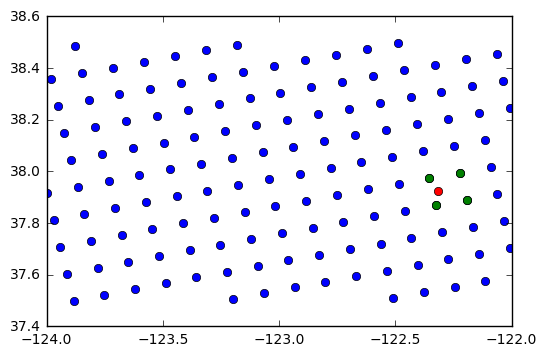

In [6]:
#test grid visually
n = 35

#do not change
df_sanfran = df.loc[(df['LAT'] < 38.50) & (df['LAT'] > 37.50) & (df['LON'] > -124.00) & (df['LON'] < -122.0)]
df_point = df.loc[(df['I'] == df_room.x1[n]) & (df['J'] == df_room.y1[n])]
df_point2 = df.loc[(df['I'] == df_room.x2[n]) & (df['J'] == df_room.y2[n])]
df_point3 = df.loc[(df['I'] == df_room.x3[n]) & (df['J'] == df_room.y3[n])]
df_point4 = df.loc[(df['I'] == df_room.x4[n]) & (df['J'] == df_room.y4[n])]

plt.clf()
plt.plot(df_sanfran.LON, df_sanfran.LAT,'o')
plt.plot(df_room.lon[n],df_room.lat[n],'ro')
plt.plot(df_point.LON,df_point.LAT,'go')
plt.plot(df_point2.LON,df_point2.LAT,'go')
plt.plot(df_point3.LON,df_point3.LAT,'go')
plt.plot(df_point4.LON,df_point4.LAT,'go')
plt.show()

In [7]:
#get all unique combinations

#do not change
x1 = df_room.x1.tolist()
x2 = df_room.x2.tolist()
x3 = df_room.x3.tolist()
x4 = df_room.x4.tolist()

y1 = df_room.y1.tolist()
y2 = df_room.y2.tolist()
y3 = df_room.y3.tolist()
y4 = df_room.y4.tolist()

unique_grid_points = []

for n in range(len(x1)):
    tup = (x1[n],y1[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)
        
    tup = (x2[n],y2[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)
    
    tup = (x3[n],y3[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)
        
    tup = (x4[n],y4[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)

        
unique_grid_points.sort()
print unique_grid_points

[(146.0, 207.0), (146.0, 208.0), (146.0, 209.0), (147.0, 207.0), (147.0, 208.0), (147.0, 209.0), (147.0, 210.0), (148.0, 207.0), (148.0, 208.0), (148.0, 209.0), (148.0, 210.0)]


In [11]:
#fetch all needed profiles

#do not change
for n,info in enumerate(folder_time_pair):
    for entry in unique_grid_points:
        
        x,y = entry
        lat, lon = df.loc[(df['I'] == x) & (df['J'] == y)].LAT.item(), df.loc[(df['I'] == x) & (df['J'] == y)].LON.item()
        print info[0],info[1],lat,lon

        #First time point is AXXX-YYY, second is BXXX-YYY, ... (maxium suffix is len is 8)
        ident = chr(n + ord('A'))
        suffix = '%s%i-%i' %(ident,int(x),int(y))
        
        subprocess.call("/Users/Pat/Hysplit4/exec/profile "
                        "-d%s "
                        "-f%s "
                        "-y%s -x%s "
                        "-o%s "
                        "-p%s".replace('\xe2','').replace('\x80','').replace('\xa8','')
                        %(folder_nam12, info[0], str(lat), str(lon), info[1], suffix), shell=True)
        print 'Got profile: %i/%i' %(int(x),int(y))
print 'Done'

20161103_nam12 15 37.7425 -122.4312
Got profile: 146/207
20161103_nam12 15 37.8472 -122.4584
Got profile: 146/208
20161103_nam12 15 37.9517 -122.4856
Got profile: 146/209
20161103_nam12 15 37.7639 -122.2988
Got profile: 147/207
20161103_nam12 15 37.8686 -122.3259
Got profile: 147/208
20161103_nam12 15 37.9732 -122.353
Got profile: 147/209
20161103_nam12 15 38.0777 -122.3801
Got profile: 147/210
20161103_nam12 15 37.7853 -122.1664
Got profile: 148/207
20161103_nam12 15 37.8899 -122.1933
Got profile: 148/208
20161103_nam12 15 37.9945 -122.2203
Got profile: 148/209
20161103_nam12 15 38.099 -122.2473
Got profile: 148/210
20161103_nam12 18 37.7425 -122.4312
Got profile: 146/207
20161103_nam12 18 37.8472 -122.4584
Got profile: 146/208
20161103_nam12 18 37.9517 -122.4856
Got profile: 146/209
20161103_nam12 18 37.7639 -122.2988
Got profile: 147/207
20161103_nam12 18 37.8686 -122.3259
Got profile: 147/208
20161103_nam12 18 37.9732 -122.353
Got profile: 147/209
20161103_nam12 18 38.0777 -122.380

In [8]:
#read in all 4 profiles, fetch the 16 points and interpolation

#do not change
profile_identifiers = ['A','B']
df_8pts_profile = pd.DataFrame(columns = ['temp','wnd_spd','wnd_dir','relh','alt','time_ident'])

vec_A = [np.nan,np.nan,np.nan,np.nan,np.nan,'A']
vec_B = [np.nan,np.nan,np.nan,np.nan,np.nan,'B']

def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
        
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        #print "ValueError('(x, y) not within the rectangle')"
        return np.nan

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)


for n in range(len(df_room)):
    #this flag will trigger, if there is not upper or lower level
    skip_flag = 0
    
    for t in profile_identifiers:
        
        #read in the 4 profiles of each line in df_room
        #profile1
        
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x1[n]),int(df_room.y1[n]))
        df_prf1 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat1, lon1 = df.loc[(df['I'] == int(df_room.x1[n])) & (df['J'] == int(df_room.y1[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x1[n])) & (df['J'] == int(df_room.y1[n]))].LON.item()

        #get the values for the level 1 lower than the alt
        df_prf1_mod = df_prf1.loc[lambda x: df_prf1.HGTS.m<df_room.alt[n],:]
        if len(df_prf1_mod) > 0:
            #print df_prf1_mod.iloc[-1,:]
            uwnd_dir1_low = df_prf1_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir1_low = df_prf1_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir1_low = 270 - (np.arctan2(vwnd_dir1_low, uwnd_dir1_low) * (180 / np.pi))
            if wnd_dir1_low > 360:
                wnd_dir1_low = wnd_dir1_low - 360
            hgts1_low = df_prf1_mod.iloc[-1,:].HGTS.m
            temp1_low = df_prf1_mod.iloc[-1,:].TEMP.oC
            relh1_low = df_prf1_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd1_low = df_prf1_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd1_low = df_prf1_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd1_low = np.sqrt(np.square(uwnd_spd1_low)+np.square(vwnd_spd1_low))
            #print wnd_dir1_low, hgts1_low, temp1_low, relh1_low, wnd_spd1_low
        else:
            skip_flag = 1

        #get the values for the level 1 higher than the alt
        df_prf1_mod = df_prf1.loc[lambda x: df_prf1.HGTS.m>df_room.alt[n],:]
        if len(df_prf1_mod) > 0:
            #print df_prf1_mod.iloc[0,:]
            uwnd_dir1_hi = df_prf1_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir1_hi = df_prf1_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir1_hi = 270 - (np.arctan2(vwnd_dir1_hi, uwnd_dir1_hi) * (180 / np.pi))
            if wnd_dir1_hi > 360:
                wnd_dir1_hi = wnd_dir1_hi - 360
            hgts1_hi = df_prf1_mod.iloc[0,:].HGTS.m
            temp1_hi = df_prf1_mod.iloc[0,:].TEMP.oC
            relh1_hi = df_prf1_mod.iloc[0,:]['RELH']['%']
            uwnd_spd1_hi = df_prf1_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd1_hi = df_prf1_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd1_hi = np.sqrt(np.square(uwnd_spd1_hi)+np.square(vwnd_spd1_hi))
            #print wnd_dir1_hi, hgts1_hi, temp1_hi, relh1_hi, wnd_spd1_hi
        else:
            skip_flag = 1

        #profile2
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x2[n]),int(df_room.y2[n]))
        df_prf2 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat2, lon2 = df.loc[(df['I'] == int(df_room.x2[n])) & (df['J'] == int(df_room.y2[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x2[n])) & (df['J'] == int(df_room.y2[n]))].LON.item()



        #get the values for the level 1 lower than the alt
        df_prf2_mod = df_prf2.loc[lambda x: df_prf2.HGTS.m<df_room.alt[n],:]
        if len(df_prf2_mod) > 0:
            #print df_prf2_mod.iloc[-1,:]
            uwnd_dir2_low = df_prf2_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir2_low = df_prf2_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir2_low = 270 - (np.arctan2(vwnd_dir2_low, uwnd_dir2_low) * (180 / np.pi))
            if wnd_dir2_low > 360:
                wnd_dir2_low = wnd_dir2_low - 360
            hgts2_low = df_prf2_mod.iloc[-1,:].HGTS.m
            temp2_low = df_prf2_mod.iloc[-1,:].TEMP.oC
            relh2_low = df_prf2_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd2_low = df_prf2_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd2_low = df_prf2_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd2_low = np.sqrt(np.square(uwnd_spd2_low)+np.square(vwnd_spd2_low))
            #print wnd_dir2_low, hgts2_low, temp2_low, relh2_low, wnd_spd2_low
        else:
            skip_flag = 1



        #get the values for the level 1 higher than the alt
        df_prf2_mod = df_prf2.loc[lambda x: df_prf2.HGTS.m>df_room.alt[n],:]
        if len(df_prf2_mod) > 0:
            #print df_prf2_mod.iloc[0,:]
            uwnd_dir2_hi = df_prf2_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir2_hi = df_prf2_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir2_hi = 270 - (np.arctan2(vwnd_dir2_hi, uwnd_dir2_hi) * (180 / np.pi))
            if wnd_dir2_hi > 360:
                wnd_dir2_hi = wnd_dir2_hi - 360
            hgts2_hi = df_prf2_mod.iloc[0,:].HGTS.m
            temp2_hi = df_prf2_mod.iloc[0,:].TEMP.oC
            relh2_hi = df_prf2_mod.iloc[0,:]['RELH']['%']
            uwnd_spd2_hi = df_prf2_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd2_hi = df_prf2_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd2_hi = np.sqrt(np.square(uwnd_spd2_hi)+np.square(vwnd_spd2_hi))
            #print wnd_dir2_hi, hgts2_hi, temp2_hi, relh2_hi, wnd_spd2_hi
        else:
            skip_flag = 1


        #profile3
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x3[n]),int(df_room.y3[n]))
        df_prf3 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat3, lon3 = df.loc[(df['I'] == int(df_room.x3[n])) & (df['J'] == int(df_room.y3[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x3[n])) & (df['J'] == int(df_room.y3[n]))].LON.item()



        #get the values for the level 1 lower than the alt
        df_prf3_mod = df_prf3.loc[lambda x: df_prf3.HGTS.m<df_room.alt[n],:]
        if len(df_prf3_mod) > 0:
            #print df_prf3_mod.iloc[-1,:]
            uwnd_dir3_low = df_prf3_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir3_low = df_prf3_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir3_low = 270 - (np.arctan2(vwnd_dir3_low, uwnd_dir3_low) * (180 / np.pi))
            if wnd_dir3_low > 360:
                wnd_dir3_low = wnd_dir3_low - 360
            hgts3_low = df_prf3_mod.iloc[-1,:].HGTS.m
            temp3_low = df_prf3_mod.iloc[-1,:].TEMP.oC
            relh3_low = df_prf3_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd3_low = df_prf3_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd3_low = df_prf3_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd3_low = np.sqrt(np.square(uwnd_spd3_low)+np.square(vwnd_spd3_low))
            #print wnd_dir3_low, hgts3_low, temp3_low, relh3_low, wnd_spd3_low
        else:
            skip_flag = 1


        #get the values for the level 1 higher than the alt
        df_prf3_mod = df_prf3.loc[lambda x: df_prf3.HGTS.m>df_room.alt[n],:]
        if len(df_prf3_mod) > 0:
            #print df_prf3_mod.iloc[0,:]
            uwnd_dir3_hi = df_prf3_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir3_hi = df_prf3_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir3_hi = 270 - (np.arctan2(vwnd_dir3_hi, uwnd_dir3_hi) * (180 / np.pi))
            if wnd_dir3_hi > 360:
                wnd_dir3_hi = wnd_dir3_hi - 360
            hgts3_hi = df_prf3_mod.iloc[0,:].HGTS.m
            temp3_hi = df_prf3_mod.iloc[0,:].TEMP.oC
            relh3_hi = df_prf3_mod.iloc[0,:]['RELH']['%']
            uwnd_spd3_hi = df_prf3_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd3_hi = df_prf3_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd3_hi = np.sqrt(np.square(uwnd_spd3_hi)+np.square(vwnd_spd3_hi))
            #print wnd_dir3_hi, hgts3_hi, temp3_hi, relh3_hi, wnd_spd3_hi
        else:
            skip_flag = 1

        #profile4
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x4[n]),int(df_room.y4[n]))
        df_prf4 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat4, lon4 = df.loc[(df['I'] == int(df_room.x4[n])) & (df['J'] == int(df_room.y4[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x4[n])) & (df['J'] == int(df_room.y4[n]))].LON.item()



        #get the values for the level 1 lower than the alt
        df_prf4_mod = df_prf4.loc[lambda x: df_prf4.HGTS.m<df_room.alt[n],:]
        if len(df_prf4_mod) > 0:
            #print df_prf4_mod.iloc[-1,:]
            uwnd_dir4_low = df_prf4_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir4_low = df_prf4_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir4_low = 270 - (np.arctan2(vwnd_dir4_low, uwnd_dir4_low) * (180 / np.pi))
            if wnd_dir4_low > 360:
                wnd_dir4_low = wnd_dir4_low - 360
            hgts4_low = df_prf4_mod.iloc[-1,:].HGTS.m
            temp4_low = df_prf4_mod.iloc[-1,:].TEMP.oC
            relh4_low = df_prf4_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd4_low = df_prf4_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd4_low = df_prf4_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd4_low = np.sqrt(np.square(uwnd_spd4_low)+np.square(vwnd_spd4_low))
            #print wnd_dir4_low, hgts4_low, temp4_low, relh4_low, wnd_spd4_low
        else:
            skip_flag = 1

        #get the values for the level 1 higher than the alt
        df_prf4_mod = df_prf4.loc[lambda x: df_prf4.HGTS.m>df_room.alt[n],:]
        if len(df_prf4_mod) > 0:
            #print df_prf1_mod.iloc[0,:]
            uwnd_dir4_hi = df_prf4_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir4_hi = df_prf4_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir4_hi = 270 - (np.arctan2(vwnd_dir4_hi, uwnd_dir4_hi) * (180 / np.pi))
            if wnd_dir4_hi > 360:
                wnd_dir4_hi = wnd_dir4_hi - 360
            hgts4_hi = df_prf4_mod.iloc[0,:].HGTS.m
            temp4_hi = df_prf4_mod.iloc[0,:].TEMP.oC
            relh4_hi = df_prf4_mod.iloc[0,:]['RELH']['%']
            uwnd_spd4_hi = df_prf4_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd4_hi = df_prf4_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd4_hi = np.sqrt(np.square(uwnd_spd4_hi)+np.square(vwnd_spd4_hi))
            #print wnd_dir4_hi, hgts4_hi, temp4_hi, relh4_hi, wnd_spd4_hi
        else:
            skip_flag = 1


        if skip_flag == 0:
            #do the 8 point interpolation (first bilinear (4point) then linear (2xbilinear))

            #get the most outer rectangular around the point for proper bilinear interpolation
            lat_mid = (((lat1+lat2)/2) + ((lat3+lat4)/2)) / 2
            lon_mid = (((lon1+lon3)/2) + ((lon2+lon4)/2)) / 2
            
            if abs(lat1-lat_mid) > abs(lat2-lat_mid):
                bilin_x1 = lat1
            else:
                bilin_x1 = lat2
                   
            if abs(lat3-lat_mid) > abs(lat4-lat_mid):
                bilin_x2 = lat3
            else:
                bilin_x2 = lat4
                
            if abs(lon1-lon_mid) > abs(lon3-lon_mid):
                bilin_y1 = lon1
            else:
                bilin_y1 = lon3
                
            if abs(lon2-lon_mid) > abs(lon4-lon_mid):
                bilin_y2 = lon2
            else:
                bilin_y2 = lon4

            #print lat1,lat2,lat3,lat4,lon1,lon3,lon2,lon4
            #print bilin_x1,df_room.lat[n],bilin_x2,bilin_y1,df_room.lon[n],bilin_y2
            #hgts
            par_input = [hgts1_low,hgts2_low,hgts3_low,hgts4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            hgts_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [hgts1_hi,hgts2_hi,hgts3_hi,hgts4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            hgts_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)


            #temp
            par_input = [temp1_low,temp2_low,temp3_low,temp4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            temp_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [temp1_hi,temp2_hi,temp3_hi,temp4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            temp_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [temp_low, temp_hi]
            temp = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #wnd_spd
            par_input = [wnd_spd1_low,wnd_spd2_low,wnd_spd3_low,wnd_spd4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [wnd_spd1_hi,wnd_spd2_hi,wnd_spd3_hi,wnd_spd4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [wnd_spd_low, wnd_spd_hi]
            wnd_spd = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #wnd_dir
            par_input = [wnd_dir1_low,wnd_dir2_low,wnd_dir3_low,wnd_dir4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_dir_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [wnd_dir1_hi,wnd_dir2_hi,wnd_dir3_hi,wnd_dir4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_dir_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [wnd_dir_low, wnd_dir_hi]
            wnd_dir = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #wnd_spd
            par_input = [wnd_spd1_low,wnd_spd2_low,wnd_spd3_low,wnd_spd4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [wnd_spd1_hi,wnd_spd2_hi,wnd_spd3_hi,wnd_spd4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [wnd_spd_low, wnd_spd_hi]
            wnd_spd = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #relh
            par_input = [relh1_low,relh2_low,relh3_low,relh4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            relh_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [relh1_hi,relh2_hi,relh3_hi,relh4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            relh_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [relh_low, relh_hi]
            relh = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            if t == 'A':
                vec_A = [temp, wnd_spd, wnd_dir, relh, df_room.alt[n],'A']
                df_8pts_profile.loc[len(df_8pts_profile)] = [vec_A[i] for i in range(len(vec_A))]
            elif t == 'B':
                vec_B = [temp, wnd_spd, wnd_dir, relh, df_room.alt[n],'B']
                df_8pts_profile.loc[len(df_8pts_profile)] = [vec_B[i] for i in range(len(vec_B))]
            #elif t == 'C':
            #   vec_C = [temp, wnd_spd, wnd_dir, relh, df_room.alt[n],'C']
            #   df_8pts_profile.loc[len(df_8pts_profile)] = [vec_C[i] for i in range(len(vec_C))]

        #interpolation in time
        vec_final = []

        for m in range(4):
            profile_times = [(dt.timedelta(hours = 18) + dt.timedelta(hours = 1,minutes = 30)).total_seconds(), 
                             (dt.timedelta(hours = 21) + dt.timedelta(hours = 1,minutes = 30)).total_seconds()]
            profile_values = [vec_A[m],vec_B[m]]

            vec_final.append(np.interp(df_room.time_est[n].total_seconds(), profile_times, profile_values))
        vec_final.append(df_room.alt[n])
        vec_final.append('Final')
        df_8pts_profile.loc[len(df_8pts_profile)] = [vec_final[i] for i in range(len(vec_final))]

        print 'Finished level: %i, %sm' %(n, df_room.alt[n])

df_8pts_profile    



Finished level: 0, 60.0m
Finished level: 0, 60.0m
Finished level: 1, 162.0m
Finished level: 1, 162.0m
Finished level: 2, 268.0m
Finished level: 2, 268.0m
Finished level: 3, 369.0m
Finished level: 3, 369.0m
Finished level: 4, 469.0m
Finished level: 4, 469.0m
Finished level: 5, 570.0m
Finished level: 5, 570.0m
Finished level: 6, 678.0m
Finished level: 6, 678.0m
Finished level: 7, 779.0m
Finished level: 7, 779.0m
Finished level: 8, 882.0m
Finished level: 8, 882.0m
Finished level: 9, 984.0m
Finished level: 9, 984.0m
Finished level: 10, 1090.0m
Finished level: 10, 1090.0m
Finished level: 11, 1193.0m
Finished level: 11, 1193.0m
Finished level: 12, 1293.0m
Finished level: 12, 1293.0m
Finished level: 13, 1399.0m
Finished level: 13, 1399.0m
Finished level: 14, 1500.0m
Finished level: 14, 1500.0m
Finished level: 15, 1604.0m
Finished level: 15, 1604.0m
Finished level: 16, 1704.0m
Finished level: 16, 1704.0m
Finished level: 17, 1820.0m
Finished level: 17, 1820.0m
Finished level: 18, 1920.0m
Finish

,temp,wnd_spd,wnd_dir,relh,alt,time_ident
0,NaN,NaN,NaN,NaN,60.0,Final
1,NaN,NaN,NaN,NaN,60.0,Final
2,NaN,NaN,NaN,NaN,162.0,Final
3,NaN,NaN,NaN,NaN,162.0,Final
4,13.665395,5.363411,58.936768,63.655505,268.0,A
5,13.665395,5.363411,58.936768,63.655505,268.0,Final
6,14.442417,4.158541,64.656418,68.733729,268.0,B
7,13.665395,5.363411,58.936768,63.655505,268.0,Final
8,14.354050,6.224823,51.583484,59.476107,369.0,A
9,14.354050,6.224823,51.583484,59.476107,369.0,Final


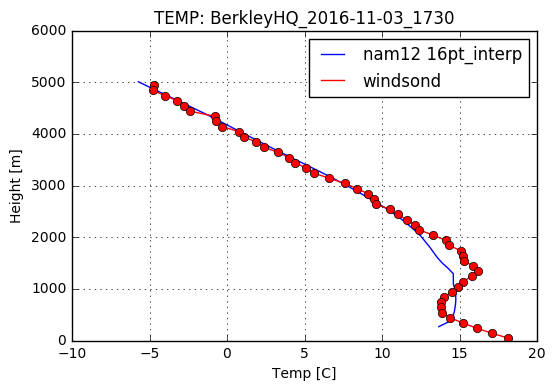

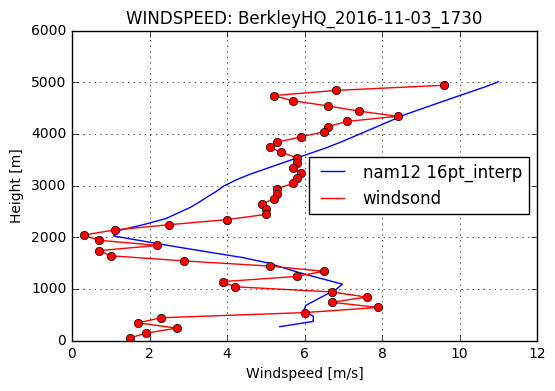

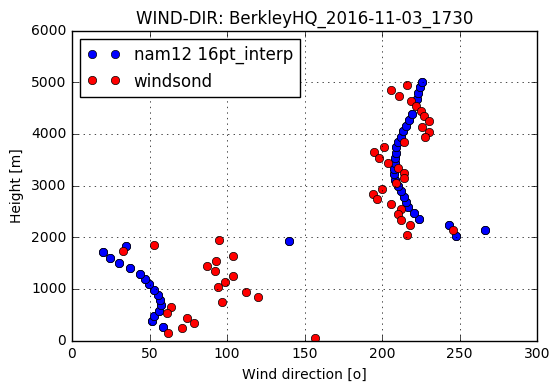

In [9]:
nam12_h_offset = ' 16pt_interp'#is added to the end of the describing legend text of the plot 'Nam12...)
#nam12_h_offset_B = '+21h'


#dp not change
pp = PdfPages(folder + 'Comparison_WS_NAM12(interp16pts)_%s.pdf' %foldername_basic) 
#nam12profiles
df_8pts_profile_A = df_8pts_profile.loc[df_8pts_profile.time_ident == 'Final']
#df_8pts_profile_B = df_8pts_profile.loc[df_8pts_profile.time_ident == 'B']


#dataframe for windsond data
df_ws = pd.read_csv(folder_ws+filename_ws, header = [0,1], delim_whitespace = 1)

#x = temp, y = height
plt.clf()
plt.figure(1)
plt.plot(df_8pts_profile_A.temp,df_8pts_profile_A.alt,'b',label = 'nam12'+nam12_h_offset)
#plt.plot(df_8pts_profile_B.temp,df_8pts_profile_B.alt,'g',label = 'nam12'+nam12_h_offset_B)
plt.plot(df_ws['temp'],df_ws['alt']+ground_height,'r', label = 'windsond')
plt.plot(df_ws['temp'],df_ws['alt']+ground_height,'ro')
plt.ylabel('Height [m]')
plt.xlabel('Temp [C]')
plt.title('TEMP: '+plot_title)
plt.grid(True)
plt.legend(loc='best')
plt.savefig(pp, format='pdf')
#plt.show()



#x = temp, y = windspeed
plt.figure(2)
plt.plot(df_8pts_profile_A.wnd_spd,df_8pts_profile_A.alt,'b',label = 'nam12'+nam12_h_offset)
#plt.plot(df_8pts_profile_B.wnd_spd,df_8pts_profile_B.alt,'g',label = 'nam12'+nam12_h_offset_B)
plt.plot(df_ws['spd'],df_ws['alt']+ground_height,'r', label = 'windsond')
plt.plot(df_ws['spd'],df_ws['alt']+ground_height,'ro')
plt.ylabel('Height [m]')
plt.xlabel('Windspeed [m/s]')
plt.title('WINDSPEED: '+plot_title)
plt.grid(True)
plt.legend(loc='best')
pp.savefig()
#plt.show()



#x = wind-dir, y = height

plt.figure(3)
plt.plot(df_8pts_profile_A.wnd_dir,df_8pts_profile_A.alt,'bo',label = 'nam12'+nam12_h_offset)
#plt.plot(df_8pts_profile_B.wnd_dir,df_8pts_profile_B.alt,'g',label = 'nam12'+nam12_h_offset_B)
plt.plot(df_ws['wind-dir'],df_ws['alt']+ground_height,'ro', label = 'windsond')
#plt.plot(df_ws['wind-dir'],df_ws['alt']+ground_height,'r')
plt.ylabel('Height [m]')
plt.xlabel('Wind direction [o]')
plt.title('WIND-DIR: '+plot_title)
plt.grid(True)
plt.legend(loc='best')
pp.savefig()

pp.close()            

plt.show()